В этом ноутбуке я пытался кластеризовать изображения без полной разметки изображений(только 5% для подсчета качества модели). 

# Imports

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [125]:
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import copy

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


## Load data

In [126]:
DATA_DIR = Path('../input/EyesDataset/')
files = sorted(list(DATA_DIR.rglob('*.jpg')))
train_files, test_files = train_test_split(files, test_size=0.05, shuffle=False)

In [127]:
DATA_MODES = ['train', 'test']
DEVICE = torch.device("cuda")

In [128]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return (np.array(image)/255).flatten()

In [129]:
X_train = np.array([load_sample(x) for x in train_files])
X_test = np.array([load_sample(x) for x in test_files])

In [130]:
X_test_conv = X_test.reshape(-1, 1, 24, 24)
X_train_conv = X_train.reshape(-1, 1, 24, 24)

In [131]:
with open('test_labels.npy', 'rb') as f:
    test_labels = np.load(f)

## Part-labeling

Разметка 5% данных

In [38]:
test_labels = []

In [ ]:
for x in tqdm(X_test):
    plt.figure()
    plt.imshow(x.reshape(24,24), cmap='gray')
    plt.show()
    test_labels.append(int(input()))
    plt.close()

In [40]:
test_labels = np.array(test_labels)

In [51]:
with open('test_labels.npy', 'wb') as f:
    np.save(f, test_labels)

In [59]:
test_labels = np.load('test_labels.npy')

0 - открытые глаза

1 - закрытые

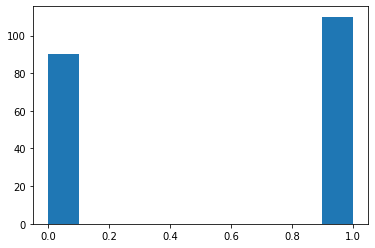

In [133]:
fig = plt.figure()
plt.hist(test_labels)
fig.savefig('../plots/hist_test_labels')

# Functions

In [148]:
def eer_score(truth, pred):
    fpr, tpr, _ = roc_curve(truth, pred, pos_label=1)
    fnr = 1 - tpr
    EER = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return EER

In [170]:
def calc_metrics(truth, pred):
    inverse = lambda x : x if x > 0.5 else 1 - x
    
    acc = inverse(accuracy_score(truth, pred))
    f1 = inverse(f1_score(truth, pred))
    eer = inverse(eer_score(truth, pred))
    
    print('acc: {:.6f}\nf1 : {:.6f}\neer : {:.6f}'.format(acc, f1, eer))
    return

In [171]:
def show_clusters(X, labels, name):
    columns = 4
    rows = 10
    
    first_x = [x for i, x in enumerate(X) if (labels[i] == 1)]
    second_x = [x for i, x in enumerate(X) if (labels[i] == 0)]
    
    fig1 = plt.figure(figsize=(8, 16))
    
    for i in range(0, 20):
        fig1.add_subplot(rows, columns, i+1)
        plt.imshow(first_x[i].reshape(24,24), cmap='gray')
        plt.title('first cluster')
    for i in range(20, 40):
        fig1.add_subplot(rows, columns, i+1)
        plt.imshow(second_x[i].reshape(24,24), cmap='gray')
        plt.title('second cluster') 
    plt.show()
    fig1.savefig('../plots/' + str(name) + '.png')

# K-means

In [172]:
kmean = KMeans(n_clusters=2, random_state=0).fit(X_train)
kmean_test_labels = kmean.predict(X_test)

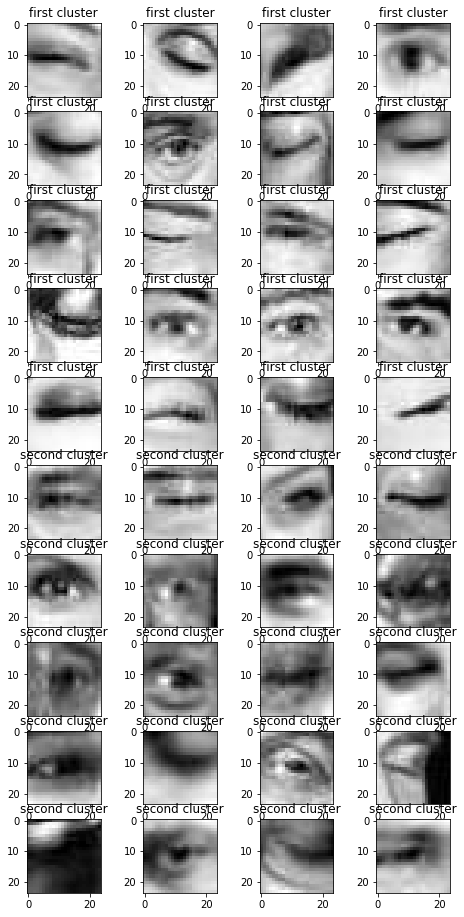

In [173]:
show_clusters(X_test, kmean_test_labels, 'kmean')

In [174]:
calc_metrics(test_labels, kmean_test_labels)

acc: 0.600000
f1 : 0.615385
eer : 0.622222


# PCA + k-means

Попробуем снизить размерность данных и обучить k-means.

In [175]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

In [176]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [177]:
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(X_train_pca)

In [178]:
kmean_pca_test_labels = kmeans_pca.predict(X_test_pca)

In [179]:
centers = kmeans_pca.cluster_centers_

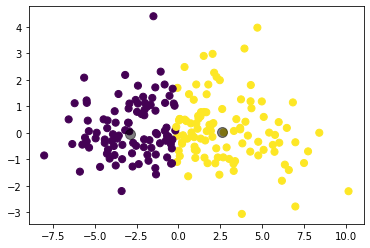

In [180]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=kmean_pca_test_labels,
            s=50, cmap='viridis')
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.savefig('../plots/pca_clusters.png')

Нормальных кластеров не наблюдается на графике.

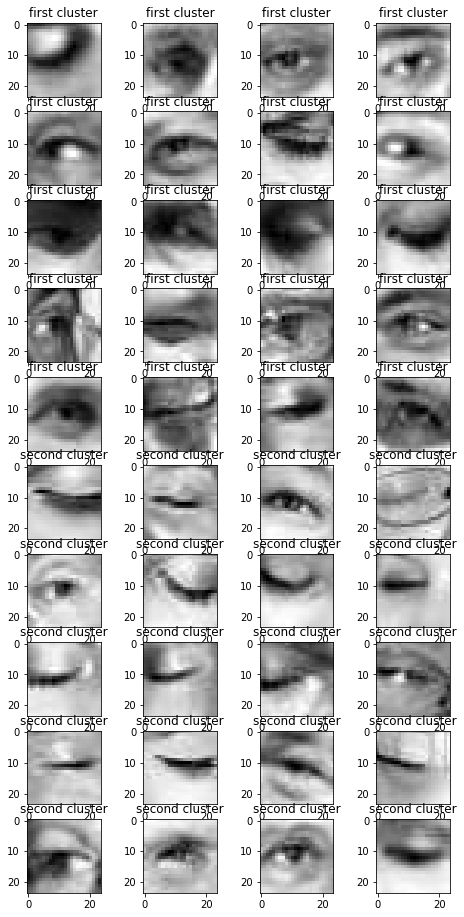

In [181]:
show_clusters(X_test, kmean_pca_test_labels, 'pca_kmean')

In [183]:
calc_metrics(test_labels, kmean_pca_test_labels)

acc: 0.600000
f1 : 0.566038
eer : 0.622222


# Deep approach

In [184]:
class EyesDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(24, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
#             transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3, fill=0),
#             transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((24, 24))
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x
        
    def _prepare_sample(self, image):
        image = image.resize((24, 24))
        return np.array(image)

In [185]:
train_dataset = EyesDataset(train_files, mode='train')
test_dataset = EyesDataset(test_files, mode='test')

In [186]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

Модель вариационного автоэнкодера, который приводит тензоры в latent-space к среднему 0 и стандартному отклонению 1.

In [187]:
class VAE(nn.Module):
    def __init__(self, dim_code=100):
        super(VAE, self).__init__()
        self.begin_encoder = nn.Sequential(
            nn.Linear(24 * 24, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
        )
        self.latent1 = nn.Linear(250, dim_code)
        self.latent2 = nn.Linear(250, dim_code)
        self.begin_decoder = nn.Sequential(
            nn.Linear(dim_code, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(500, 24 * 24),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.begin_encoder(x)
        mu = self.latent1(x)
        logsigma = self.latent2(x)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z):
        z = self.begin_decoder(z)
        reconstruction = self.out(z)        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Общий лосс:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем кросс-энтропию.

In [188]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu * mu - torch.exp(2 * logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    c = x.size(0) * x.size(1)
    return KL_divergence(mu, logsigma) / c + log_likelihood(x, reconstruction)

In [189]:
def plot_eyes(sam1, sam2):
    sam1 = sam1.cpu().detach().numpy()
    sam2 = sam2.cpu().detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(sam1.reshape(24,24), cmap='gray')
    axes[1].imshow(sam2.reshape(24,24), cmap='gray')
    fig.tight_layout()

И обучим модель:

In [190]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x.to(DEVICE)
        # flatten for linear vae
        if not isinstance(net, ConvVAE):
            train_x = train_x.view(-1, 24 * 24)

        optimizer.zero_grad()

        mu, logsigma, reconstruction = net(train_x)
        
        # calculate loss
        loss = loss_fn(train_x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [191]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for test_x in test_loader:
        test_x = test_x.to(DEVICE)
        
        # flatten for linear vae
        if not isinstance(net, ConvVAE):
            test_x = test_x.view(-1, 24 * 24)
        
        mu, logsigma, reconstruction = net(test_x)
        
        # calculate loss
        
        loss = loss_fn(test_x, mu, logsigma, reconstruction)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter
    ind = np.random.randint(len(test_x))
    plot_eyes(test_x[ind], reconstruction[ind])

    return test_ep_loss

In [192]:
def train(net, train_loader, test_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if e % 5 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                          "Loss: {:.6f}...".format(train_loss),
                          "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

In [193]:
vae = VAE().to(DEVICE)

optimizer = torch.optim.Adam(vae.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = loss_vae

In [ ]:
vae_train_losses, vae_test_losses = train(vae, train_loader, test_loader, criterion, optimizer, 100, scheduler)

In [163]:
torch.save(vae.state_dict(), '../weights/weights_vae_100.pth')

In [194]:
vae.load_state_dict(torch.load('../weights/weights_vae_100.pth'))
vae.eval();

# VAE + k-means

Проверка гиппотезы о том, что k-means сможет разделить вектора в latent-space.

In [195]:
X_test_embed, _ = vae.encode(torch.FloatTensor(X_test).to(DEVICE))
X_test_embed = X_test_embed.cpu().detach().numpy()

In [196]:
X_train_embed, _ = vae.encode(torch.FloatTensor(X_train).to(DEVICE))
X_train_embed = X_train_embed.cpu().detach().numpy()

In [197]:
X_train_embed.shape

(3800, 100)

In [198]:
kmean_vae = KMeans(n_clusters=2, random_state=0).fit(X_train_embed)
kmean_vae_test_labels = kmean_vae.predict(X_test_embed)

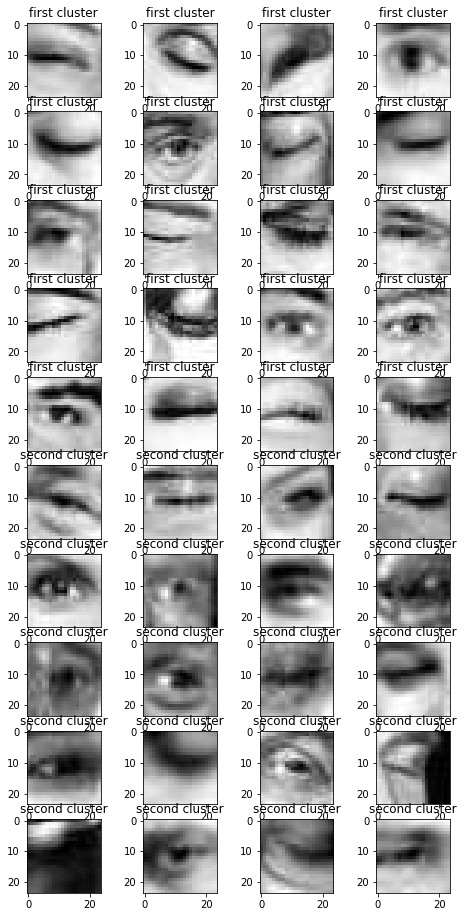

In [199]:
show_clusters(X_test, kmean_vae_test_labels, 'kmean_vae')

In [200]:
calc_metrics(test_labels, kmean_vae_test_labels)

acc: 0.610000
f1 : 0.628571
eer : 0.622222


## VAE + tsne

Визуализация векторов в latent-space с помощью TSNE.

In [201]:
X_test_embed = TSNE().fit_transform(X_test_embed)

(200, 2)


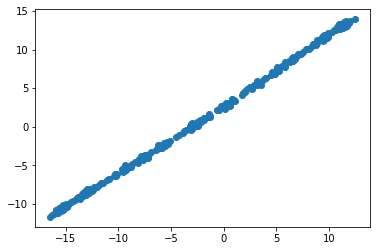

In [202]:
print(X_test_embed.shape)

fig = plt.figure()
x, y = np.hsplit(X_test_embed, 2)
plt.scatter(x, y)
fig.savefig('../plots/tsne_vae.png')

In [203]:
kmeans_vae = KMeans(n_clusters=2, random_state=0).fit(X_test_embed)

In [204]:
labels = kmeans_vae.predict(X_test_embed)

In [205]:
centers = kmeans_vae.cluster_centers_

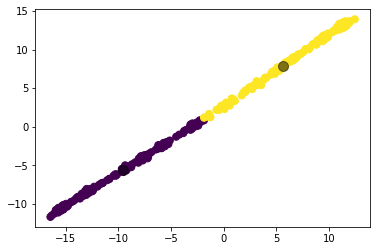

In [206]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test_embed[:, 0], X_test_embed[:, 1], c=labels,
            s=50, cmap='viridis')
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

fig.savefig('../plots/tsne_vae_clusters.png')

In [207]:
calc_metrics(test_labels, labels)

acc: 0.610000
f1 : 0.628571
eer : 0.622222


# Conv VAE

Модель сверточного вариационного автоэнкодера.

In [208]:
class ConvVAE(nn.Module):
    def __init__(self, dim_code=100):
        super(ConvVAE, self).__init__()
        self.dim_code = dim_code
        
        self.begin_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2), # 32x11x11
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2), # 64x5x5
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), #128x2x2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=1), #256x1x1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.latent1 = nn.Linear(256, dim_code)
        self.latent2 = nn.Linear(256, dim_code)
        self.begin_decoder = nn.Sequential(
            nn.ConvTranspose2d(dim_code, 64, kernel_size=3), #64x3x3
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), #32x8x8
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2), #16x18x18
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=7, stride=1), #1x24x24
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.begin_encoder(x)
        mu = self.latent1(x)
        logsigma = self.latent2(x)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z):
        z = z.view(-1, self.dim_code, 1, 1)
        reconstruction = self.begin_decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [209]:
conv_vae = ConvVAE().to(DEVICE)

optimizer = torch.optim.Adam(conv_vae.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = loss_vae

In [ ]:
vae_train_losses, vae_test_losses = train(conv_vae, train_loader, test_loader, criterion, optimizer, 100, scheduler)

In [210]:
conv_vae.load_state_dict(torch.load('../weights/weights_conv_vae_100.pth'))
conv_vae.eval();

In [179]:
torch.save(conv_vae.state_dict(), '../weights/weights_conv_vae_100.pth')

In [211]:
X_train_embed_conv, _ = conv_vae.encode(torch.FloatTensor(X_train_conv).to(DEVICE))
X_train_embed_conv = X_train_embed_conv.cpu().detach().numpy()

In [212]:
X_test_embed_conv, _ = conv_vae.encode(torch.FloatTensor(X_test_conv).to(DEVICE))
X_test_embed_conv = X_test_embed_conv.cpu().detach().numpy()

# Clustering Conv VAE

In [213]:
X_train_embed_conv.shape

(3800, 100)

In [214]:
kmeans_vae_conv = KMeans(n_clusters=2, random_state=0).fit(X_train_embed_conv)

In [215]:
labels_kmeans_vae_conv = kmeans_vae_conv.predict(X_test_embed_conv)

In [216]:
calc_metrics(test_labels, labels_kmeans_vae_conv)

acc: 0.535000
f1 : 0.555024
eer : 0.544444


Как оказалось, k-means не может разделить и вектора из latent-space сверточного автоэнкодера.